# Víceruký bandita

viz [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) str. 164

##### Zadání úlohy: 

* Vstupujete do kasína s kýblem $n_{coins}$ mincí. 
* V kasínu je $n_{bandits}$ výherních mašin. 
* Každá mašina vrací vhozenou minci s neznámou pravděpodobností $p_i$. 
* Z kasína si nesmíte odnést žádnou minci, se kterou vstupujete, ale můžete si odnést všechny mince, které vám mašiny vrátí. 
* Úkolem je odnést si co nejvíce.


In [2]:
from bandits import Bandits

bandits = Bandits(n_bandits = 5)

print(bandits)

[B(0.941),B(0.144),B(0.793),B(0.623),B(0.473)]


## Strategie

Strategie říká jak vybrat banditu pro vhození další mince.

Strategie je implementována jako funktor inicializovaný parametrem:

* `n_bandits` — celkový počet banditů

Strategie implementuje metodu `__call__` s parametry:

* `thrown` — pole s počtem mincí dříve vhozených do mašin
* `returned` — pole s počtem mincí dříve vrácených mašinami


#### Připravené strategie

##### RegularStrategy

* Strategie pravidelně střídá mašiny bez ohledu na jejich výstup

##### RandomStrategy

* Strategie náhodně vybírá mašiny  bez ohledu na jejich výstup






In [3]:
from bandits import Strategy
from bandits import BayesStrategy, RepeatStrategy

class RegularStrategy(Strategy):
    """ samples bandits regulary 1,2,3... """
    
    def __call__(self, thrown, returned):
        return sum(thrown) % n_bandits
    
    
class RandomStrategy(Strategy):
    """ samples bandits randomly """
    
    def __call__(self, thrown, returned):
        return np.random.randint(0, n_bandits, 1)[0]

#### Test strategie




In [4]:
import numpy as np
import pandas as pd
import copy


n_bandits = 5
n_coins = 1000


bandits = Bandits(n_bandits)
print(bandits)

strategies = [RegularStrategy(n_bandits), RandomStrategy(n_bandits), RepeatStrategy(n_bandits), BayesStrategy(n_bandits)]

returns = np.zeros([n_coins, len(strategies)])

for j in range(len(strategies)):

    bandits.reset()    # reset vnitřního stavu bandity
    for i in range(n_coins):
        bandits.throw(strategies[j], 1)
        returns[i, j] = bandits.tot_returned / bandits.tot_thrown

df_ret = pd.DataFrame(returns, columns=[s.name() for s in strategies])

print(df_ret.head())


[B(0.495),B(0.004),B(0.309),B(0.753),B(0.159)]
   RegularStrategy  RandomStrategy  RepeatStrategy  BayesStrategy
0         0.000000        0.000000        1.000000       0.000000
1         0.000000        0.500000        0.500000       0.500000
2         0.333333        0.666667        0.333333       0.333333
3         0.500000        0.750000        0.500000       0.250000
4         0.400000        0.800000        0.600000       0.200000


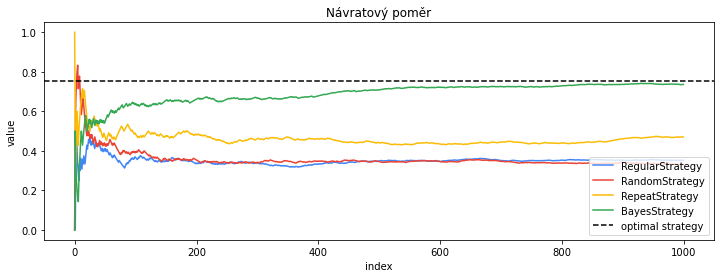

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = ['#4285F4','#EA4335','#FBBC05','#34A853']

plt.figure(figsize=(12,4))
sns.lineplot(data=pd.melt(df_ret.reset_index(), var_name='strategy', id_vars='index'),
             x ='index', y='value', hue='strategy', palette=palette[:df_ret.shape[1]], 
             ).set(title='Návratový poměr')
plt.axhline(max([b.rate for b in bandits.bandits]), color='black', linestyle='--', label= 'optimal strategy')
plt.legend(loc='lower right');

## Experimentální porovnání

* Porovnání strategií v kontrolovaném experimentu

* Všem strategiím bude opakovaně předložena stejná sada náhodně generovaných bandidtů
* Výsledky budou porovnány napříč experimenty

#### Parametry experimentu

* `n_bandits` — počet banditů
* `n_runs` — počet běhů
* `n_coins` — počet mincí v každém běhu
* `strategies` — seznam testovaných strategií

#### Výstup experimentu

* `df_ret` — tabulka návratnosti běhů pro všechny strategie

#### Průběh experimentu


In [6]:
n_bandits = 5
n_coins = 100
n_runs = 200

strategies = [RegularStrategy(n_bandits), RandomStrategy(n_bandits), RepeatStrategy(n_bandits), BayesStrategy(n_bandits, 0.1)]


np.random.seed(0)
returns = np.zeros([n_runs, len(strategies)])

for i in range(n_runs):

    bandits = Bandits(n_bandits)

    for j in range(len(strategies)):

        bandits.reset()                                   # reset vnitřního stavu bandity
        returns[i, j] = bandits.throw(strategies[j], n_coins)

df_ret = pd.DataFrame(returns, columns=[s.name() for s in strategies])

print(df_ret.head())


   RegularStrategy  RandomStrategy  RepeatStrategy  BayesStrategy
0             60.0            51.0            64.0           63.0
1             34.0            34.0            46.0           86.0
2             34.0            41.0            61.0           80.0
3             49.0            56.0            90.0           81.0
4             57.0            52.0            69.0           90.0


### Výsledky experimentu

#### Výnos napříč experimenty

* rozdělení výnosů strategií napříč experimenty graficky

/home/ppascenko/.local/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ppascenko/.local/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ppascenko/.local/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ppascenko/.local/lib/python3.10/site-packages/seaborn/distributions.py:1699: Futur

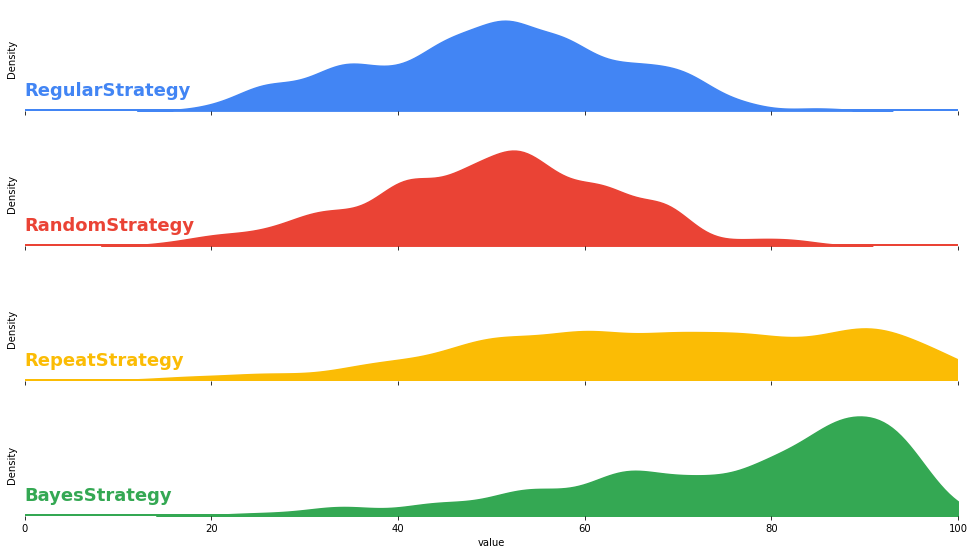

In [7]:
def label(x, color, label, right=False):
    plt.gca().text(1 if right else 0, .2, label, fontweight="bold", color=color, size=18, ha="right" if right else "left", va="center", transform=plt.gca().transAxes)

g=sns.FacetGrid(pd.melt(df_ret, var_name='strategy'), row="strategy", hue="strategy", 
                  aspect=7, height=2, palette=palette[:df_ret.shape[1]], xlim=(0,n_coins));

g.map(sns.kdeplot, "value", shade=True, alpha=1, lw=1.5, bw=0.2).map(plt.axhline, y=0, lw=4).map(label, x="value")
g.set_titles("") #set title to blank
g.set(yticks=[]) #set y ticks to blank
g.despine(bottom=True, left=True); #remove 'spines'

#### Průměrný výnos

* `mean` — průměrný výnos strategie
* `std` — směrodatná odchylka výnosu strategie
* `std_mean` — směrodatná odchylka odhadu střední hodnoty výnosu


In [8]:
df_agg = pd.melt(df_ret, var_name='strategy').groupby('strategy').aggregate(
    [np.mean, np.std]).droplevel(0, axis='columns').reset_index().sort_values('mean')

df_agg['std_mean'] = df_agg['std'] / np.sqrt(n_runs)

df_agg

,strategy,mean,std,std_mean
1,RandomStrategy,50.080,13.005356,0.919618
2,RegularStrategy,50.360,13.249458,0.936878
3,RepeatStrategy,68.590,19.117250,1.351794
0,BayesStrategy,76.245,16.490441,1.166050


#### Očekávaný výnos

* odhad střední hodnoty výnosu pro jednotlivé strategie

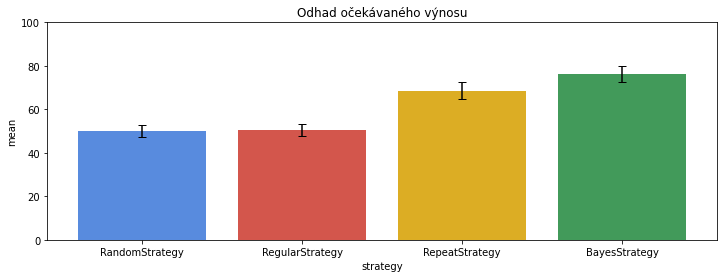

In [9]:
n_std = 3

plt.figure(figsize=(12,4))
sns.barplot(x='strategy', y='mean', data=df_agg, palette=palette[:df_ret.shape[0]]).set(title='Odhad očekávaného výnosu', ylim=(0, n_coins));
plt.errorbar(x=df_agg['strategy'], y=df_agg['mean'], yerr=n_std*df_agg["std_mean"], fmt="none", c= "k", capsize=4);

#### Podíl vítězství

* podíl případů, kdy se strategie ukázala být vítězná


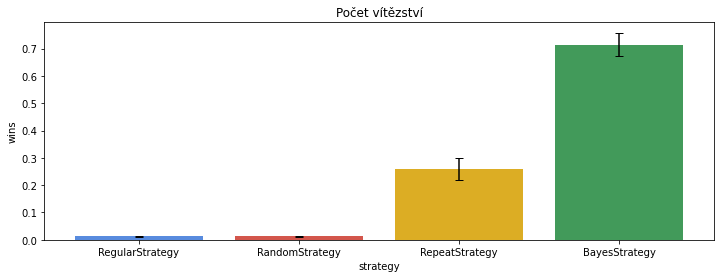

In [10]:
n_std = 3

df_max = df_ret.eq(df_ret.max(axis=1), axis=0)
df_wins = pd.DataFrame(df_max.divide(df_max.sum(axis=1), axis=0).mean(axis=0)).reset_index().rename(columns={'index':'strategy', 0:'wins'})
df_wins['err'] = n_std*df_wins['wins'] * (1-df_wins['wins']) / (n_runs**0.5)
df_wins

plt.figure(figsize=(12,4))
sns.barplot(x='strategy', y='wins', data=df_wins, palette=palette[:df_wins.shape[0]]).set(title='Počet vítězství');
plt.errorbar(x=df_wins['strategy'], y=df_wins['wins'], yerr=df_wins["err"], fmt="none", c= "k", capsize=4);

### Ztráta na vítěze

/home/ppascenko/.local/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ppascenko/.local/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ppascenko/.local/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ppascenko/.local/lib/python3.10/site-packages/seaborn/distributions.py:1699: Futur

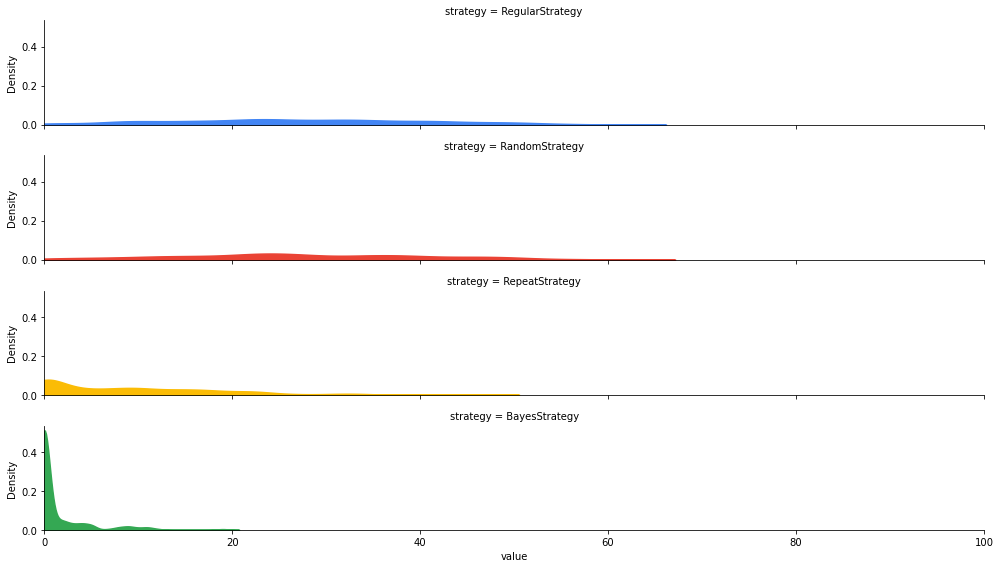

In [11]:
df_los=-df_ret.sub(df_ret.max(axis=1), axis=0)

g=sns.FacetGrid(pd.melt(df_los, var_name='strategy'), row="strategy", hue="strategy", 
                  aspect=7, height=2, palette=palette[:df_ret.shape[1]], xlim=(0,n_coins));

g.map(sns.kdeplot, "value", shade=True, alpha=1, lw=1.5, bw=0.2);


In [12]:
df_los_agg = pd.melt(df_los, var_name='strategy').groupby('strategy').aggregate(
    [np.mean, np.std]).droplevel(0, axis='columns').reset_index().sort_values('mean')

df_los_agg['std_mean'] = df_los_agg['std'] / np.sqrt(n_runs)

df_los_agg

,strategy,mean,std,std_mean
0,BayesStrategy,1.285,2.895808,0.204765
3,RepeatStrategy,8.940,9.220166,0.651964
2,RegularStrategy,27.170,13.611298,0.962464
1,RandomStrategy,27.450,13.559751,0.958819


### Vnitřní reprezentace Bayesovské strategie

* beta rozdělení pro vzorkování po stanoveném počtu kroků


In [32]:
from bandits import BayesStrategy
import scipy.stats as stats

np.random.seed(0)

n_coins = 10000
bandits = Bandits(n_bandits)

print(bandits)

bayes_strategy = BayesStrategy(n_bandits)

for i in range(n_coins):
    bandits.throw(bayes_strategy, 1)

#sampling = np.zeros(n_bandits)    
    
#for i in range(n_sample):
#    sampling[bayes_strategy(bandits.thrown, bandits.returned)]+=1   

x = np.arange(0,1,0.001)
db = pd.DataFrame({'x':x})
for i in range(n_bandits):
    db[f'bandit_{i}'] = stats.beta.pdf(x, bayes_strategy.alphas[i], bayes_strategy.betas[i])

[B(0.549),B(0.715),B(0.603),B(0.545),B(0.424)]


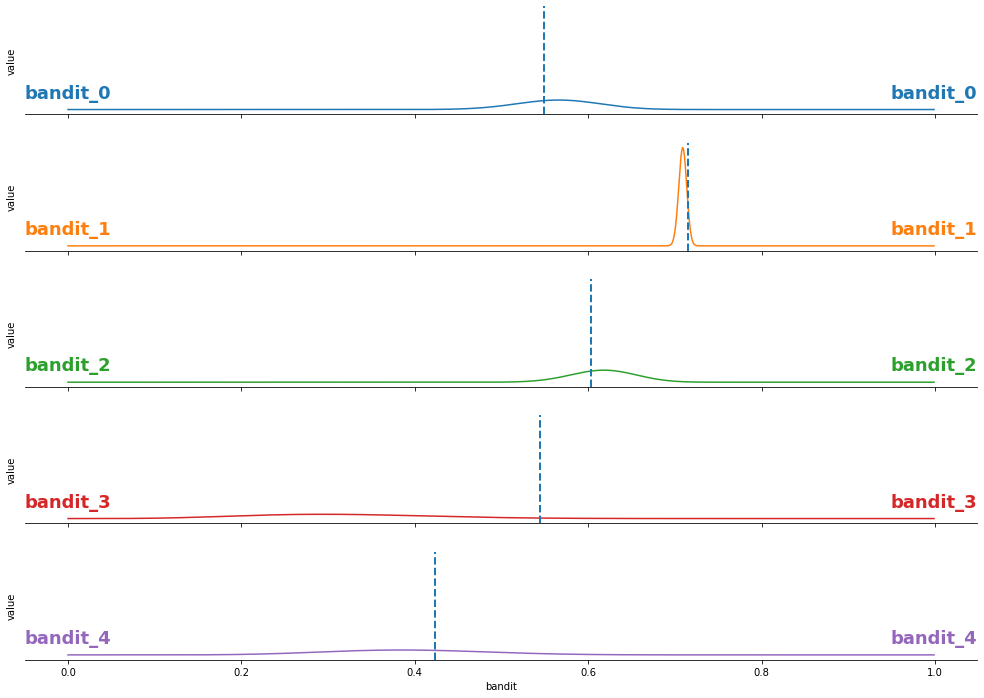

In [33]:
db_smpl=pd.melt(db, id_vars='x', var_name='bandit')
db_smpl['smpl']='1'
g=sns.FacetGrid(db_smpl, row="bandit", hue="bandit", aspect=7, height=2)
g.map(sns.lineplot, 'x', "value").map(label, "bandit").map(label, 'bandit', label='smpl', right=True).set_titles("").set(yticks=[]);
g.despine(bottom=False, left=True); 

for ax, pos in zip(g.axes.flat, [b.rate for b in bandits.bandits]):
    ax.axvline(x=pos, linestyle='--', lw=2)

In [28]:
db_smpl

,x,bandit,value,smpl
0,0.000,bandit_0,0.000000e+00,1
1,0.001,bandit_0,9.115408e-222,1
2,0.002,bandit_0,4.307567e-197,1
3,0.003,bandit_0,1.157981e-182,1
4,0.004,bandit_0,1.989088e-172,1
5,0.005,bandit_0,1.718862e-164,1
6,0.006,bandit_0,5.224675e-158,1
7,0.007,bandit_0,1.576311e-152,1
8,0.008,bandit_0,8.768338e-148,1
9,0.009,bandit_0,1.340756e-143,1
